# <p style="background-color:#018cb7; font-size:100%; text-align:left; color:#FFFFFF; padding: 15px 5px 15px 25px; border-radius: 15px;">Porto Seguro’s Safe Driver Prediction - Kaggle</p>

## Predict if a driver will file an insurance claim next year

<img src='./img/safe-driving-730x432.jpeg' style='height:400px; border-radius: 5px;'/>

---
# <p style="background-color:#018cb7; font-size:100%; text-align:left; color:#FFFFFF; padding: 15px 5px 15px 25px; border-radius: 15px;">Contents:</p>

* [1. Introduction](#1)
    * [1.1 Data Description](#1.1)
    * [1.2 Libraries](#1.2)
    * [1.3 Loading Dataset](#1.3)
* [2. Preprocessing & Feature Engineering](#2)
    * [2.1 SMOTE](#2.1)
    * [2.2 Cross-validation](#2.2)
    * [2.3 Feature Selection](#2.3)
* [3. Models](#3)
    * [3.1 Lightgbm](#3.1)
    * [3.2 Neural Networks](#3.2)
* [4. Evaluation](#4)
* [5. Kaggle Submission](#5)

<a id="1"></a>
# <p style="background-color:#018cb7; font-size:100%; text-align:left; color:#FFFFFF; padding: 15px 5px 15px 25px; border-radius: 15px;">1- Introduction</p>

<img title="Porto Seguro" src="img/porto-seguro-logo-1-3.png" alt="Porto Seguro" style='height:80px; padding: 10px; padding-right: 15px;' align="center"> 

[Porto Seguro](https://www.portoseguro.com.br/en/institutional) is one of the largest insurance companies in Brazil specialized in car and home insurance. Located in São Paulo, Porto Seguro has been one of the leading insurers in Brazil since its foundation in 1945.

A key challenge faced by all major insurers is, when it comes to car insurance, how to address fairness towards good drivers and try not to penalize those who have a good driving history on account of a few bad drivers. Inaccuracies in car insurance claim predictions usually raise its cost for good drivers and reduce the price for bad ones.

Porto Seguro has been applying Machine Learning for more than 20 years and intends to make car insurance more accessible to everyone. Thinking about that, the company created an online competition to help them explore new and more powerful ML methods.

<img title="Porto Seguro" src="img/Kaggle_logo.png" alt="Porto Seguro" style='height:80px; padding: 10px; padding-right: 15px' align="center">

[Kaggle](https://www.kaggle.com/) is an online community of data scientists and allows users to find and publish data sets, explore and build ML models, and enter competitions to solve data science challenges.

In this [competition](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/), the challenge is build a model that predicts the probability that a car insurance policy holder will file a claim next year.

<a id="1.1"></a>
## Data Description

In the train and test data:

- Features that belong to similar groupings are tagged as such in the feature names (e.g., `ind`, `reg`, `car`, `calc`). 
- Feature names include the postfix `bin` to indicate binary features and `cat` to indicate categorical features.
- Features __without__ these designations are either __continuous or ordinal__.
- Values of `-1` indicate that the feature was missing from the observation. 
- The `target` columns signifies whether or not a claim was filed for that policy holder. 

- `ind` - individuals
- `reg` - regions
- `car` - cars
- `calc` - calculated features

- `_bin` - binary 
- `_cat` - categorical

<a id="1.2"></a>
## Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import random

%matplotlib inline
matplotlib.style.use("ggplot")

import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Preprocessing
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split

# Models
import lightgbm as lgb
from lightgbm import LGBMClassifier


import time
import warnings
warnings.simplefilter('ignore', FutureWarning)

In [2]:
from platform import python_version
print('Python version:', python_version())

Python version: 3.8.5


In [3]:
# !pip install -q -U watermark
%reload_ext watermark
%watermark -a "Leandro Pessini" --iversions

Author: Leandro Pessini

seaborn   : 0.11.1
numpy     : 1.19.2
plotly    : 4.14.3
sklearn   : 0.23.2
matplotlib: 3.3.2
lightgbm  : 3.1.1
pandas    : 1.1.3



<a id="1.3"></a>
## Loading Dataset

In [4]:
# Kaggle
#kaggle_path = "../input/porto-seguro-safe-driver-prediction/"

# Local
local_path = "./data/"

In [5]:
train_df = pd.read_csv(local_path + "train.csv").set_index('id')
test_df = pd.read_csv(local_path + "test.csv").set_index('id')

---
As per description, there are a few variables called calculated features. In one of the discussions, it was highlighted that some kind of transformation was applied in order to generate these features. I will drop these features and apply the transformations on my best judgment.

In [6]:
train_df = train_df.drop(train_df.filter(regex='_calc').columns, axis=1)
test_df = test_df.drop(test_df.filter(regex='_calc').columns, axis=1)

In [7]:
print('Train Dataset - Number of rows are',train_df.shape[0], 'and number of columns are ',train_df.shape[1])
print('Test Dataset - Number of rows are',test_df.shape[0], 'and number of columns are ',test_df.shape[1])

Train Dataset - Number of rows are 595212 and number of columns are  38
Test Dataset - Number of rows are 892816 and number of columns are  37


<a id="2"></a>
# <p style="background-color:#018cb7; font-size:100%; text-align:left; color:#FFFFFF; padding: 15px 5px 15px 25px; border-radius: 15px;">2- Preprocessing & Feature Engineering</p>

## Imbalanced data

`target` variable 1 means that a claim was filed and 0 that it was not claimed.

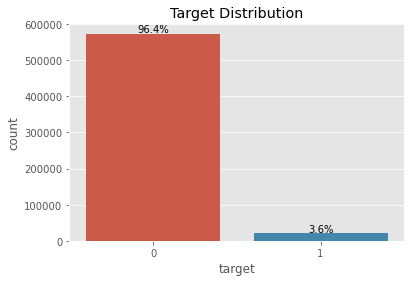

In [8]:
y = train_df.target
ax = sns.countplot(y,label="Count")

total_size = len(train_df)

# Display the target value ratio at the top of the bar
for patch in ax.patches:
    height = patch.get_height()
    width = patch.get_width()
    left_coord = patch.get_x()
    percent = height/total_size*100

    ax.text(x=left_coord + width/2.0, 
            y=height + 3000,
            s='{:1.1f}%'.format(percent),
            ha='center')

ax.set_title('Target Distribution');

## Missing values

Values of __`-1`__ indicate that the feature was missing from the observation.

In [9]:
vars_with_missing = []

for f in train_df.columns:
    missings = train_df[train_df[f] == -1][f].count()
    if missings > 0:
        vars_with_missing.append(f)
        missings_perc = missings/train_df.shape[0]
        
        print('Variable {} has {} records ({:.2%}) with missing values'.format(f, missings, missings_perc))
        
print('\nIn total, there are {} variables with missing values'.format(len(vars_with_missing)))

Variable ps_ind_02_cat has 216 records (0.04%) with missing values
Variable ps_ind_04_cat has 83 records (0.01%) with missing values
Variable ps_ind_05_cat has 5809 records (0.98%) with missing values
Variable ps_reg_03 has 107772 records (18.11%) with missing values
Variable ps_car_01_cat has 107 records (0.02%) with missing values
Variable ps_car_02_cat has 5 records (0.00%) with missing values
Variable ps_car_03_cat has 411231 records (69.09%) with missing values
Variable ps_car_05_cat has 266551 records (44.78%) with missing values
Variable ps_car_07_cat has 11489 records (1.93%) with missing values
Variable ps_car_09_cat has 569 records (0.10%) with missing values
Variable ps_car_11 has 5 records (0.00%) with missing values
Variable ps_car_12 has 1 records (0.00%) with missing values
Variable ps_car_14 has 42620 records (7.16%) with missing values

In total, there are 13 variables with missing values


---
Only `ps_car_03_cat` and `ps_car_05_cat` have a large number of missing values.
- ps_car_03_cat has 411231 records (69.09%)
- ps_car_05_cat has 266551 records (44.78%)

__I will drop those variables???__

__Add 'number of missing values per data' as a new feature?__
train_df['num_missing'] = (all_data==-1).sum(axis=1)


Add num_missin to remaining_features
remaining_features.append('num_missing')

<a id="2.1"></a>
## Metadata

To make data management easier, a meta-info about the variables is added to the DataFrame. It will help handling those variables later on the analysis, data viz and modeling.

- __level__: categorical, numerical, binary
- __dtype__: int, float, str

We do not have information on which features are ordinal or not so a meta-info __numerical__ will be added in order to apply __Normalization__ later.

In [10]:
data = []
for f in train_df.columns:
    
    if 'bin' in f or f == 'target':
        level = 'binary'
    elif 'cat' in f:
        level = 'categorical'
    elif train_df[f].dtype == float:
        level = 'numerical'
    elif train_df[f].dtype == int:
        level = 'numerical'
    
    # Defining the data type 
    dtype = train_df[f].dtype
    
    # Creating a Dict that contains all the metadata for the variable
    f_dict = {
        'varname': f,
        'level': level,
        'dtype': dtype
    }
    
    data.append(f_dict)

In [11]:
meta = pd.DataFrame(data, columns=['varname', 'level', 'dtype'])
meta.set_index('varname', inplace=True)

In [12]:
# Example to extract all categorical variables that are not dropped
meta[(meta.level == 'categorical')].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

### Number of variables per role and level 

In [13]:
pd.DataFrame({'count' : meta.groupby(['level'])['level'].size()}).reset_index()

,level,count
0,binary,12
1,categorical,14
2,numerical,12


## Exploratory Analysis

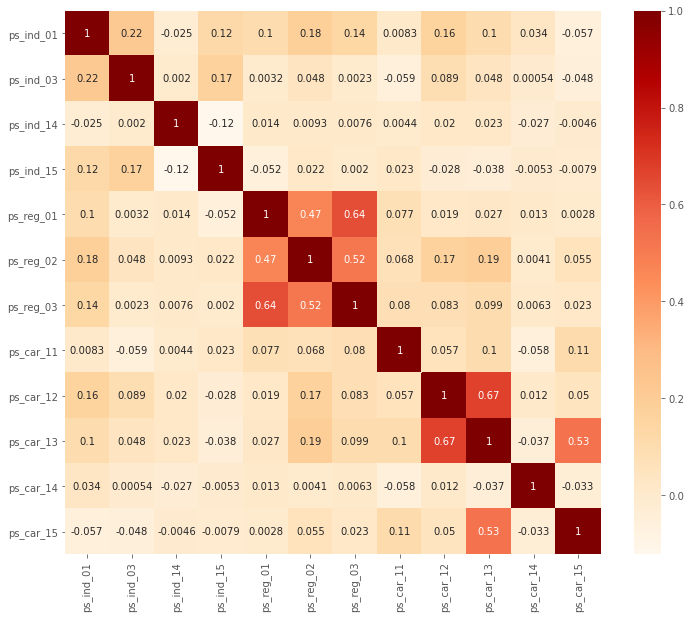

In [14]:
numerical_features = meta[(meta.level == 'numerical')].index

plt.figure(figsize=(12, 10))
cont_corr = train_df[numerical_features].corr() # Correlation between continuous features
sns.heatmap(cont_corr, annot=True, cmap='OrRd'); # Plot heatmap

There are a strong correlations between the variables:

- ps_car_12 and ps_car_13 (0.67)
- ps_reg_01 and ps_reg_03 (0.64)
- ps_reg_02 and ps_reg_03 (0.52)

Heatmap showed low number of correlated variables, we'll look at each of the highly correlated variables separately.

In [15]:
# Convert -1 from training data copy to np.NaN
train_copy = train_df.copy().replace(-1, np.NaN)
train_copy = train_copy.dropna()
s = train_copy.sample(frac=0.1)

__NOTE__: sampling was applied to speed up the process.

### ps_car_12 x ps_car_13

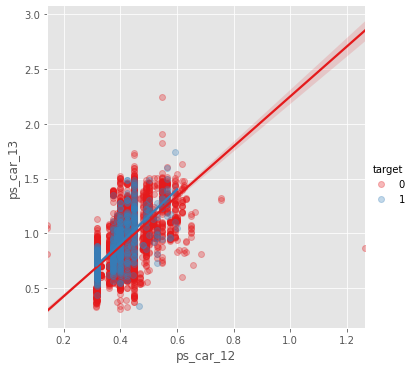

In [16]:
sns.lmplot(x='ps_car_12', y='ps_car_13', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

### ps_reg_01 x ps_reg_03

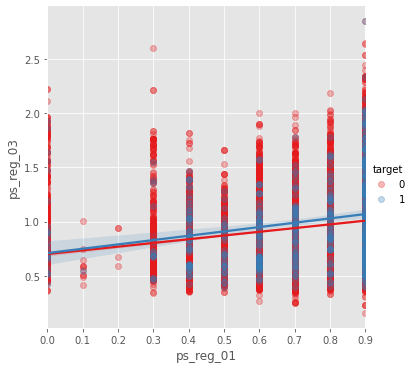

In [17]:
sns.lmplot(x='ps_reg_01', y='ps_reg_03', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

### ps_reg_02 x ps_reg_03

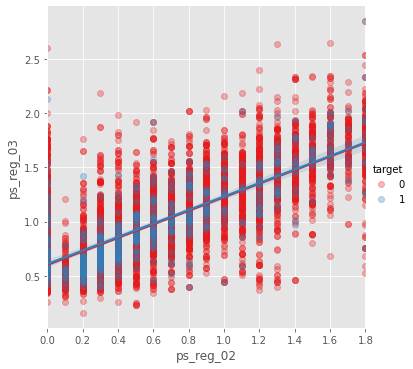

In [18]:
sns.lmplot(x='ps_reg_02', y='ps_reg_03', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

As the number of correlated variables is rather low, dimensionality reduction will not be applied and the model will do the heavy-lifting.

## Binary features

__Distribution__ of binary data and the __corresponding__ values of __target__ variable.

/Users/pessini/opt/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


<Figure size 432x288 with 0 Axes>

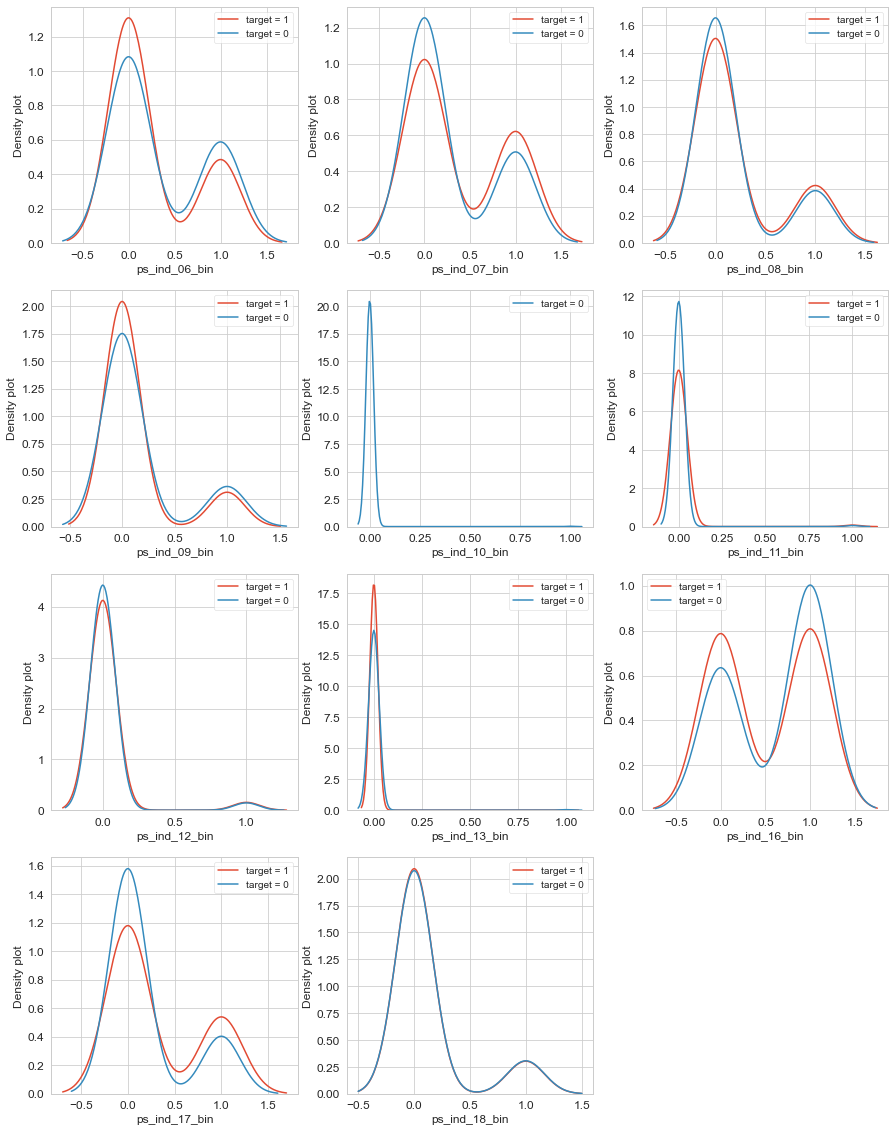

In [19]:
var = [col for col in train_copy.columns if '_bin' in col]
i = 0

s_bin = train_copy.sample(frac=0.1)
t1 = s_bin.loc[s_bin['target'] != 0]
t0 = s_bin.loc[s_bin['target'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(figsize=(15,20))

for feature in var:
    i += 1
    plt.subplot(4,3,i)
    sns.kdeplot(t1[feature], bw=0.5, label="target = 1")
    sns.kdeplot(t0[feature], bw=0.5, label="target = 0")
    plt.legend(loc='best')
    plt.ylabel('Density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)

plt.show()

---
---
---
---

<a id="2.2"></a>
## Feature Importance

As the categorical variables are already numerical, there is no need to apply LabelEncoding.

__Reference__:
>Raschka, S., & Mirjalili, V. (2019). Python Machine Learning. Zaltbommel, Netherlands: Van Haren Publishing.

In [20]:
# Feature scaling
numerical_features = meta[(meta.level == 'numerical')].index
features_n = numerical_features.to_list()
training_normalized = train_df.copy()

features = training_normalized[features_n]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

training_normalized[features_n] = features

In [21]:
training_data = training_normalized.copy()

In [22]:
lgb_params = {
        'is_unbalance': True, # because training data is extremely unbalanced
        'objective': 'binary',
        'boosting_type': 'dart',
        'learning_rate': 0.01,
        'n_estimators': 250,
        'n_jobs': 2, # number of parallel threads
        'importance_type': 'gain'
    }
features_classifier = lgb.LGBMClassifier()
features_classifier.set_params(**lgb_params)

LGBMClassifier(boosting_type='dart', importance_type='gain', is_unbalance=True,
               learning_rate=0.01, n_estimators=250, n_jobs=2,
               objective='binary')

__StratifiedKFold__: This method should be used in situations when we have a very unbalanced class.

- __'objective': 'binary'__ is because it is a classification problem

- __'learning_rate'__ Step size shrinkage used in update to prevents overfitting. After each boosting step, we can diresctly get the weights of new features. Learning rate shrinks the feature weights to make the boosting process more conservative.

- __'boosting_type'__ gbdt suffers from over-specialization, which means trees added at later iterations tend to impact the prediction of only a few instances and make a negligible contribution towards the remaining instances. Adding dropout makes it more difficult for the trees at later iterations to specialize on those few samples and hence improves the performance. For this reason I am using __DART (Dropouts meet Multiple Additive Regression Trees)__ as boosting type.

>Rashmi, K. V., & Gilad-Bachrach, R. (2015). DART: Dropouts meet Multiple Additive Regression Trees. ArXiv.

- __'n_estimators__ Number of boosted trees to fit.
- __'n_jobs': 2__ for the best speed, set this to the number of real CPU cores, not the number of threads.
- __'importance_type': 'gain'__ result contains total gains of splits which use the feature.


In [23]:
y = training_data.target
X = training_data.drop(['target'], inplace=False, axis=1)

X, X_test, y, y_test = train_test_split(X, y, test_size = 0.2)

In [24]:
kf = StratifiedKFold(n_splits=5, shuffle=True)
predicts = []

for train_index, test_index in kf.split(X, y):
    print('-'*70)
    X_train, X_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]
    
    features_classifier.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=50, eval_metric=["auc", "binary"])
    predicts.append(features_classifier.predict(X_test))

----------------------------------------------------------------------
[50]	valid_0's auc: 0.632448	valid_0's binary_logloss: 0.267364
[100]	valid_0's auc: 0.632294	valid_0's binary_logloss: 0.45304
[150]	valid_0's auc: 0.632207	valid_0's binary_logloss: 0.548235
[200]	valid_0's auc: 0.632001	valid_0's binary_logloss: 0.603
[250]	valid_0's auc: 0.632274	valid_0's binary_logloss: 0.63077
----------------------------------------------------------------------
[50]	valid_0's auc: 0.630519	valid_0's binary_logloss: 0.267433
[100]	valid_0's auc: 0.627981	valid_0's binary_logloss: 0.453228
[150]	valid_0's auc: 0.626787	valid_0's binary_logloss: 0.548497
[200]	valid_0's auc: 0.627238	valid_0's binary_logloss: 0.603291
[250]	valid_0's auc: 0.628246	valid_0's binary_logloss: 0.631039
----------------------------------------------------------------------
[50]	valid_0's auc: 0.630279	valid_0's binary_logloss: 0.26747
[100]	valid_0's auc: 0.629336	valid_0's binary_logloss: 0.453153
[150]	valid_0's 

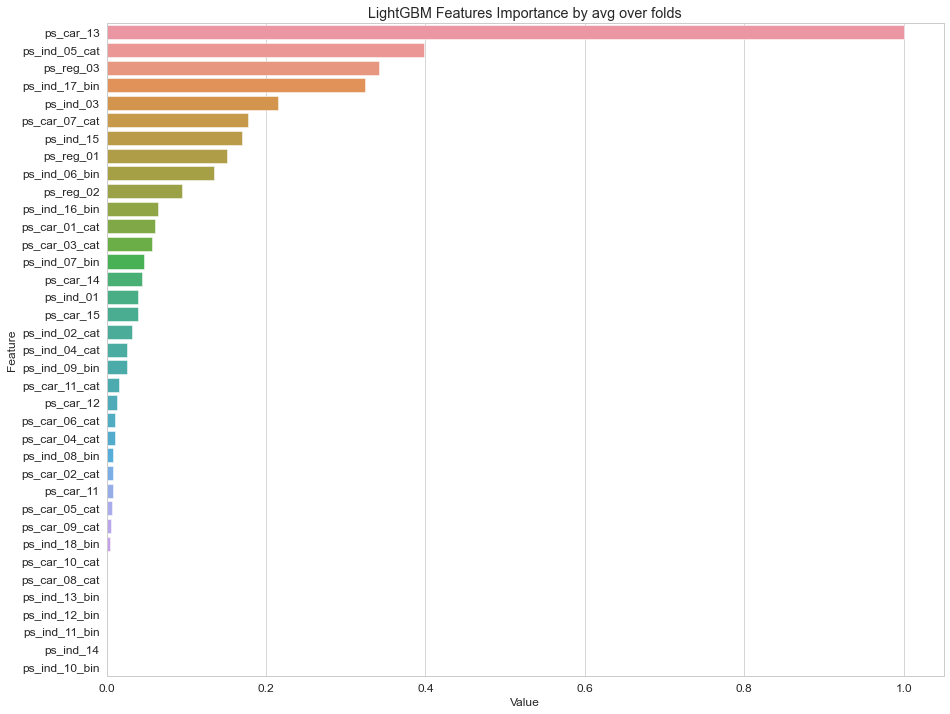

In [25]:
#Plotting features importance

feature_imp = pd.DataFrame(sorted(zip(features_classifier.feature_importances_,X.columns)), columns=['Value','Feature'])
scaler_ft = MinMaxScaler()
feature_imp['Value'] = scaler_ft.fit_transform(feature_imp['Value'].values.reshape(-1,1))

fig = plt.figure(figsize=(15, 12))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features Importance by avg over folds')
plt.savefig('./plots/lgbm_importances-01.png', dpi=fig.dpi)
locs, labels = plt.xticks()
plt.tick_params(axis='both', which='major', labelsize=12)

plt.show()

## Combining train and test data

Now that we have the Feature Importance, let's concat the train and test data in order to perform transformation on both.

In [26]:
all_data = pd.concat([train_df, test_df], ignore_index=True)
all_data = all_data.drop('target', axis=1) # Remove target value

## Dropping less important features

__SelectFromModel__ - Meta-transformer for selecting features based on importance weights.

With the get_support method we can then limit the number of variables in the train data.

>https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html

In [27]:
#sfm = SelectFromModel(model, threshold='median', prefit=True)
# threshold = 100

feat_labels = all_data.columns

sfm = SelectFromModel(features_classifier, threshold='0.05*mean', prefit=True)
print('Number of features before selection: {}'.format(all_data.shape[1]))
n_features = sfm.transform(all_data).shape[1]
print('Number of features after selection: {}'.format(n_features))
selected_vars = list(feat_labels[sfm.get_support()])

Number of features before selection: 37
Number of features after selection: 29


In [28]:
all_data_feat_sel = all_data[selected_vars]

<a id="2.2"></a>
## Feature scaling using StandardScaler

In [29]:
features_n = [col for col in all_data_feat_sel.columns if ('_cat' not in col and '_bin' not in col)]
all_data_n = all_data_feat_sel.copy()

features = all_data_n[features_n]

# using default 
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

all_data_n[features_n] = features

<a id="2.3"></a>
## One-hot encoding categorical features

In [30]:
all_data_enc = all_data_n.copy()
categoricals_features = [col for col in all_data_feat_sel.columns if '_cat' in col]

print('Before dummification we have {} variables in train'.format(all_data_enc.shape[1]))
all_data_enc = pd.get_dummies(all_data_enc, columns=categoricals_features, drop_first=True)
print('After dummification we have {} variables in train'.format(all_data_enc.shape[1]))

Before dummification we have 29 variables in train
After dummification we have 184 variables in train


<a id="3"></a>
# <p style="background-color:#018cb7; font-size:100%; text-align:left; color:#FFFFFF; padding: 15px 5px 15px 25px; border-radius: 15px;">3- Models</p>

For this project I will use 2 Ensemble ML models: `LightGBM` and `XGBoost`

## Split train and test data 

In [31]:
num_train = train_df.shape[0] # Number of train data 
final_data = all_data_enc.copy()

# Divide train data and test data
X = np.asarray(final_data[:num_train])
X_test = np.asarray(final_data[num_train:])

y = np.asarray(train_df['target'])

## Normalized Gini coefficient

![Gini](./img/gini_formula.png)

As for why use this instead of the commonly used AUC, the only reason I can think of is that a random prediction will yield a Gini score of 0 as opposed to the AUC which will be 0.5.

Besides that using the gini coefficient sets the performance of a random classifier to a score of 0... the normalization "improves" the other end of the scale and makes that the score of a perfect classifier is equal to 1 rather than a maximum achievable AUC<1. The improvement being only relative depending on whether you think a more intuitive scale is good or not. Although beyond this easier interpretation you might argue that it (the normalization) also improves generalization and comparison of different data-sets.

__Reference:__

> Hand, D. J., & Till, R. J. (2001). A Simple Generalisation of the Area Under the ROC Curve for Multiple Class Classification Problems. Machine Learning, 45(2), 171–186. https://doi.org/10.1023/a:1010920819831

In [32]:
def Gini(y_true, y_pred):
    # check and get number of samples
    assert y_true.shape == y_pred.shape
    n_samples = y_true.shape[0]

    # sort rows on prediction column
    # (from largest to smallest)
    arr = np.array([y_true, y_pred]).transpose()
    true_order = arr[arr[:, 0].argsort()][::-1, 0]
    pred_order = arr[arr[:, 1].argsort()][::-1, 0]

    # get Lorenz curves
    L_true = np.cumsum(true_order) * 1. / np.sum(true_order)
    L_pred = np.cumsum(pred_order) * 1. / np.sum(pred_order)
    L_ones = np.linspace(1 / n_samples, 1, n_samples)

    # get Gini coefficients (area between curves)
    G_true = np.sum(L_ones - L_true)
    G_pred = np.sum(L_ones - L_pred)

    # normalize to true Gini coefficient
    return G_pred * 1. / G_true

def gini_lgb(preds, dtrain):
    labels = dtrain.get_label()
    return 'gini', Gini(labels, preds), True

## LightGBM

In [37]:
lgb_params = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'is_unbalance': True,
        'metric': 'auc',
        'feature_fraction': 0.7,
        'max_bin': 255,
        'n_jobs': 2,
        'min_data_in_leaf': 1500,
        'bagging_freq': 1,
        'bagging_fraction': 0.7,
        'learning_rate': 0.01,
        'num_leaves': 30
    }

## K-fold cross validation

- __On smaller data sets__ If you have a huge data set, you can afford to slice it into three representative parts — train, test, final evaluation. Unfortunately, you don’t always have this luxury; your data set might not be large enough to slice into three representative parts. This is where cross validation comes in. K-fold cross validation prevents overfitting to your test data without further reducing the size of your training data set.
- __To get a less biased (read: optimistic) evaluation of your model__ K-fold cross validation reports on the performance of a model on several (k) samples from your training set. This gives you insight into the distribution of accuracy you are likely to see for a model.
- __When you have enough computing resources/time__ K-fold cross validation is more computationally expensive than slicing your data into three parts. It re-fits the model and tests it k-times, for each iteration, as opposed to one time. Thus, It is much more valuable with small data sets where this runtime/computational cost is not significant, and the extra partition would reduce the training data set significantly.

In [38]:
# One-dimensional array of probabilities for predicting validation data target values
val_preds_lgb = np.zeros(X.shape[0]) 
# One-dimensional array of probabilities for predicting test data target values
test_preds_lgb = np.zeros(X_test.shape[0])

evals_result = {}

# Create Stratified K Fold CV
folds = StratifiedKFold(n_splits=5, shuffle=True)

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    # The phrase that separates each fold.
    print('#'*40, f'Fold {n_fold+1} out of {folds.n_splits}', '#'*40)
    
    X_train, y_train = X[train_idx], y[train_idx] # Train data
    X_valid, y_valid = X[valid_idx], y[valid_idx] # Valid data

    # Create lgbm dataset
    dtrain = lgb.Dataset(X_train, y_train) # lgbm train dataset
    dvalid = lgb.Dataset(X_valid, y_valid) # lgbm valid dataset

    lgb_model = lgb.train(params=lgb_params,
                          train_set=dtrain,
                          num_boost_round=1500,
                          valid_sets=[dvalid, dtrain],
                          feval=gini_lgb, # Evaluation metrics for validation
                          early_stopping_rounds=200, 
                          verbose_eval=200, 
                          evals_result=evals_result)
    
    # The number of boosting iterations when the model performs best 
    best_iter = lgb_model.best_iteration
    
    # Predict probabilities using test data
    test_preds_lgb += lgb_model.predict(X_test, 
                                    num_iteration=best_iter)/folds.n_splits
    # prediction for model performance evaluation
    val_preds_lgb[valid_idx] += lgb_model.predict(X_valid, num_iteration=best_iter)
    
    # Normalized Gini coefficient for prediction probabilities
    gini_score = Gini(y_valid, val_preds_lgb[valid_idx])
    print(f'Fold {n_fold+1} gini score: {gini_score}\n')

######################################## Fold 1 out of 5 ########################################
[LightGBM] [Info] Number of positive: 17355, number of negative: 458814
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.076957 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1267
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 156
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274764
[LightGBM] [Info] Start training from score -3.274764
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.659859	training's gini: 0.319719	valid_0's auc: 0.636762	valid_0's gini: 0.273524
[400]	training's auc: 0.669573	training's gini: 0.339146	valid_0's auc: 0.640344	valid_0's gini: 0.280688
[600]	training's auc: 0.677947	training's gini: 0.355894	valid_0

## Saving the model

In [42]:
import joblib

In [43]:
# Save LightGBM model to file in the current working directory

joblib_file = "LightGBM_Model.pkl"  
joblib.dump(lgb_model, joblib_file)

['LightGBM_Model.pkl']

## Tuning the hyper-parameters

- Random Search for Hyper-Parameter Optimization
- Grid search
- Bayesian optimization

In [ ]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

param_grid = {'learning_rate': [0.1, 0.01, 0.001],
              'max_bin': [200, 300, 500],
              'min_data_in_leaf': [500, 1000, 1500],
              'feature_fraction': [0.3, 0.5, 0.7],
              'n_estimators': [400, 700, 1000, 2000, 3000],
              'num_leaves': [10, 20, 30, 40]
              }

# Regressor
grid_lgb = lgb.LGBMClassifier()

# Modelo criado com GridSearchCV
gs_cv = GridSearchCV(grid_lgb, param_grid, scoring = 'roc_auc', n_jobs = 4).fit(final_data[:num_train], train_df['target'])

# Imprime os melhors parâmetros
print('Melhores hyper-parameters: %r' % gs_cv.best_params_)

In [50]:
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [ ]:
lgb_params = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'is_unbalance': True,
        'metric': 'auc',
        'feature_fraction': 0.7,
        'max_bin': 255,
        'n_jobs': 2,
        'min_data_in_leaf': 1500,
        'bagging_freq': 1,
        'bagging_fraction': 0.7,
        'learning_rate': 0.01,
        'num_leaves': 30
    }

<a id="4"></a>
# <p style="background-color:#018cb7; font-size:100%; text-align:left; color:#FFFFFF; padding: 15px 5px 15px 25px; border-radius: 15px;">4- Evaluation</p>

In [39]:
print('LightGBM Gini Score:', Gini(y, val_preds_lgb))

LightGBM Gini Score: 0.28717603741272846


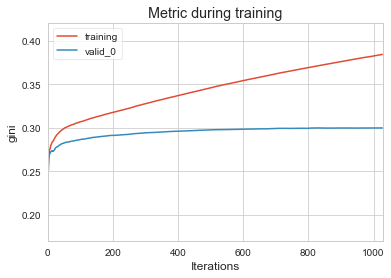

In [40]:
ax = lgb.plot_metric(evals_result, metric='gini')
plt.show()

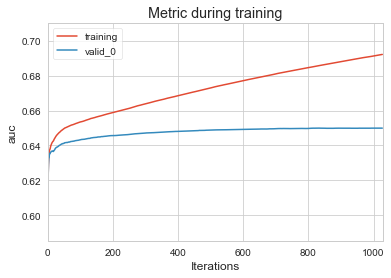

In [41]:
ax = lgb.plot_metric(evals_result, metric='auc')
plt.show()

<module 'lightgbm.plotting' from '/Users/pessini/opt/miniconda3/lib/python3.8/site-packages/lightgbm/plotting.py'>

## Loading saved model

In [ ]:
# Load from file
joblib_LightGBM_model = joblib.load(joblib_file)
joblib_LightGBM_model

In [ ]:
joblib_LightGBM_model.best_score

In [ ]:
joblib_LightGBM_model.get_split_value_histogram

In [ ]:
# Use the Reloaded Joblib Model to 
# Calculate the accuracy score and predict target values

# Calculate the Score 
score = joblib_LightGBM_model.score(X, y)  
# Print the Score
print("Test score: {0:.2f} %".format(100 * score))  

# Predict the Labels using the reloaded Model
Ypredict = joblib_LightGBM_model.predict(X_test)  

Ypredict

<a id="5"></a>
# <p style="background-color:#018cb7; font-size:100%; text-align:left; color:#FFFFFF; padding: 15px 5px 15px 25px; border-radius: 15px;">5- Kaggle Submission</p>

In [44]:
submission = pd.read_csv(local_path + 'sample_submission.csv', index_col='id')
submission['target'] = test_preds_lgb
submission.to_csv('./ignore-folder/submission2.csv')

## Score

<img src='./ignore-folder/score/scores.png' style='height:800px; border-radius: 5px;'/>

<img src='./ignore-folder/score/private_leaderboard.png' style='height:600px; border-radius: 5px;'/>